In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import random
import requests
import os
import textwrap

In [2]:
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

random.shuffle(letters2)

for k, v in zip(letters1, letters2):
  true_mapping[k] = v

###Language Model

In [3]:
# Markov Matrix
M = np.ones((26, 26))

pi = np.zeros(26)

def update_transition(ch1, ch2):
  # ord(a) = 97, ord(b) = 98
  i = ord(ch1) - 97
  j = ord(ch2) - 97
  M[i, j] += 1

def update_pi(ch):
  i = ord(ch) - 97
  pi[i] += 1

def get_word_prob(word):
  i = ord(word[0]) - 97
  logprob = np.log(pi[i])

  for ch in word[1:]:
    j = ord(ch)-97
    # print(ch)
    logprob += np.log(M[i,j])
    i = j

  return logprob

def get_seq_prob(seq):
  if type(seq)==str:
    words = seq.split()

  log_word_prob = 0
  for word in words:
    log_word_prob += get_word_prob(word)

  return log_word_prob

In [4]:
# download the file
if not os.path.exists('moby_dick.txt'):
  print("Downloading moby dick...")
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt', 'w') as f:
    f.write(r.content.decode())

In [5]:
regex = re.compile('[^a-zA-Z]') # non - alpha characters

for line in open('moby_dick.txt'):
  line = line.rstrip()
  if line:
    line = regex.sub(' ', line) # replace non-aplha characters

    tokens = line.lower().split()

    for token in tokens:
      ch0 = token[0]
      update_pi(ch0)

      for ch1 in token[1:]:
        update_transition(ch0, ch1)
        ch0 = ch1

pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [6]:
### encode a message

# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [7]:
def encode_msg(msg):
  msg = msg.lower()
  msg = regex.sub(' ', msg)

  coded_msg = []
  for ch in msg:
    coded_ch = ch # stores char, if " ", then no chnges to space char and will remain same in the encoded msg as well
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)

  return ''.join(coded_msg)

In [8]:
encoded_msg = encode_msg(original_message)

In [9]:
def decode_msg(msg, word_map):
  # msg = msg.lower()
  # msg = regex.sub(' ', msg)
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)

  return ''.join(decoded_msg)

In [10]:
dna_pool = []
for i in range(20):
  dna = list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)

In [11]:
def get_offsprings(dna_pool, num_of_offsprings):
  off_springs = []

  for dna in dna_pool:
    for i in range(num_of_offsprings):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      temp = copy[k]
      copy[k] = copy[j]
      copy[j] = temp

      off_springs.append(copy)

  return off_springs + dna_pool

In [12]:
EPOCHS = 2001
scores = np.zeros(EPOCHS)

best_dna = None
best_map = None
best_score = float('-inf')

for epoch in range(EPOCHS):
  if epoch > 0:
    dna_pool = get_offsprings(dna_pool, 3)

  dna2scores = {}
  for dna in dna_pool:
    curr_word_map = {}
    letters = list(string.ascii_lowercase)
    for k, v in zip(letters, dna):
      curr_word_map[k] = v

    decoded_msg = decode_msg(encoded_msg, curr_word_map)
    score = get_seq_prob(decoded_msg)
    # dna2scores[dna] = score
    dna2scores[''.join(dna)] = score


    if score > best_score:
      best_score = score
      best_dna = dna
      best_map = curr_word_map

  # average score for this generation
  scores[epoch] = np.mean(list(dna2scores.values()))

  # keep the best 5 dna
  # also turn them back into list of single chars
  sorted_dna = sorted(dna2scores.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]

  if epoch % 200 == 0:
    print("iter:", epoch, "score:", scores[epoch], "best so far:", best_score)

iter: 0 score: -2079.9703817394675 best so far: -1788.5687339231479
iter: 200 score: -1230.0253604777874 best so far: -1164.7296118830477
iter: 400 score: -1214.0709966896982 best so far: -1134.0203321277472
iter: 600 score: -1085.9022552364336 best so far: -963.2376944439716
iter: 800 score: -1043.5640423145985 best so far: -929.5902922650557
iter: 1000 score: -1007.9018288410666 best so far: -929.5902922650557
iter: 1200 score: -1010.8789650507724 best so far: -929.5902922650557
iter: 1400 score: -1001.8525606618747 best so far: -929.5902922650557
iter: 1600 score: -990.8320656486945 best so far: -929.5902922650557
iter: 1800 score: -1018.0844824766151 best so far: -929.5902922650557
iter: 2000 score: -1035.801794371874 best so far: -929.5902922650557


In [13]:
# use best score
decoded_message = decode_msg(encoded_msg, best_map)

print("LL of decoded message:", get_seq_prob(decoded_message))
print("LL of true message:", get_seq_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -929.5902922650557
LL of true message: -933.0312453751817
true: j, pred: q
true: k, pred: z
true: q, pred: j
true: z, pred: k


In [14]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

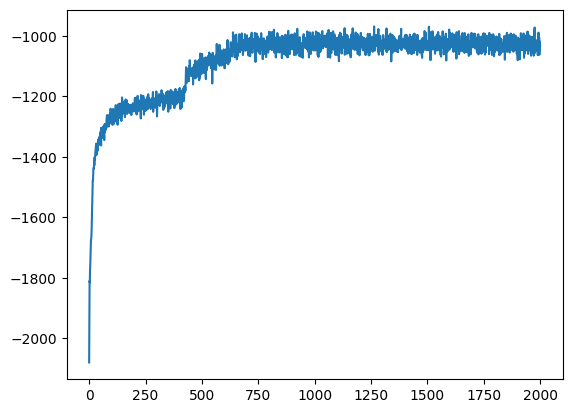

In [15]:
plt.plot(scores)
plt.show()